In [1]:
import sys
sys.path.append('/home/linxuangao')

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import torch
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import scipy

from GPNSF.model import GPNSFModel
from GPNSF.utils import *


import warnings
warnings.filterwarnings("ignore")

/home/linxuangao/.conda/envs/glx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 指定GPU设备索引
gpu_id = 1  # 使用第4张GPU（索引从0开始）
torch.cuda.set_device(gpu_id)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

print(f'Using device: {device}')
print(f'Current GPU: {torch.cuda.current_device()}')

Using device: cuda
Current GPU: 1


In [3]:
# data_dir = '/home/linxuangao/data_gpnsf/Dataset7_Mouse_Brain_ATAC'
data_dir = '/home/linxuangao/data_gpnsf/Dataset1_Mouse_Spleen1'

In [4]:
adata1 = sc.read_h5ad(f'{data_dir}/adata_RNA.h5ad')
# adata2 = sc.read_h5ad(f'{data_dir}/adata_peaks_normalized.h5ad')
adata2 = sc.read_h5ad(f'{data_dir}/adata_ADT.h5ad')

In [5]:
print(adata1)
print(adata2)

AnnData object with n_obs × n_vars = 2568 × 32285
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2568 × 21
    obsm: 'spatial'


In [6]:
sc.pp.filter_genes(adata1, min_counts=50)
print(f"RNA: 过滤后基因数: {adata1.n_vars}")
    
    # 2. 选择高变基因
sc.pp.highly_variable_genes(
        adata1, 
        n_top_genes=3000,
        flavor='seurat_v3'
    )
adata1 = adata1[:, adata1.var['highly_variable']].copy()
print(f"RNA: 选择 {adata1.n_vars} 个高变基因")
    
# 3. 标准化
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)

RNA: 过滤后基因数: 12025
RNA: 选择 3000 个高变基因


In [7]:
X_1 = adata1.X
p = X_1.shape[1]
X_2 = adata2.X
q = X_2.shape[1]
S = adata1.obsm['spatial']

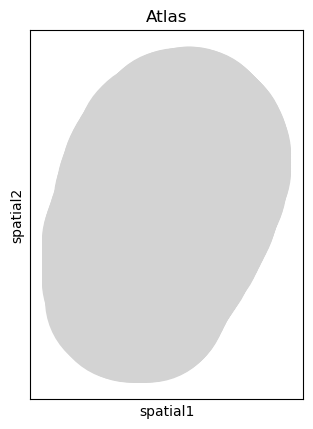

In [8]:
sc.pl.spatial(adata1, spot_size=100, title='Atlas')

In [9]:
K = 8
M = 1284

In [10]:
# 重新加载 GPNSF 并将 numpy/sparse 转为 torch 张量
# from importlib import reload
# import GPNSF.model as gp_model
# reload(gp_model)
from GPNSF.model import GPNSFModel

import numpy as np
import scipy.sparse as sp

def to_torch_tensor(x, device, dtype=torch.float32):
    if hasattr(x, "toarray"):
        x = x.toarray()  # scipy.sparse -> ndarray
    if isinstance(x, np.ndarray):
        return torch.as_tensor(x, dtype=dtype, device=device)
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    raise TypeError(f"Unsupported type: {type(x)}")

S_t = to_torch_tensor(S, device, dtype=torch.float32)
X1_t = to_torch_tensor(X_1, device, dtype=torch.float32)
X2_t = to_torch_tensor(X_2, device, dtype=torch.float32)

print('Converted ->', 'S:', S_t.shape, 'X1:', X1_t.shape, 'X2:', X2_t.shape, 'device=', device)

Converted -> S: torch.Size([2568, 2]) X1: torch.Size([2568, 3000]) X2: torch.Size([2568, 21]) device= cuda


In [11]:
from tqdm import tqdm
# 构建模型与训练循环（周期性打印 loss/ELBO/KL）
model = GPNSFModel(S=S_t, p=p, q=q, K=K, M=M, eta=10.0, num_mc_samples=3, likelihood_x2='poi', 
                   omega_type='chol', kernel_type='matern32').to(device)

# 修改1: 初始学习率设为1e-3
opt = torch.optim.Adam(model.parameters(), lr=1e-2)  # 原为 lr=5e-4

@torch.no_grad()
def compute_loglik_terms(model, X1, X2):
    # 与模型内部保持一致的 Monte Carlo 估计，并适配 X2 的两种似然模式
    W1, W2 = model.get_W1_W2()
    theta1 = model.theta1
    Hs = model.sample_H()  # (S, n, K)
    loglik1 = []
    loglik2 = []
    if model.likelihood_x2 == 'nb':
        lambda2_nb = model.lambda2_nb
    elif model.likelihood_x2 == 'bernoulli':
        lambda2_ber = model.lambda2_ber
        X2_bin = (X2 > 0).to(X2.dtype)
    else:
        lambda2_poi = model.lambda2_poi
    for t in range(Hs.size(0)):
        H = Hs[t]
        Y1 = torch.exp(H) @ W1
        Y2 = torch.exp(H) @ W2
        loglik1.append(nb_log_prob(X1, Y1, theta1).sum())
        if model.likelihood_x2 == 'nb':
            loglik2.append(nb_log_prob(X2, Y2, lambda2_nb).sum())
        elif model.likelihood_x2 == 'ber':
            p2 = torch.clamp(Y2 * lambda2_ber, min=1e-8, max=1.0 - 1e-8)
            loglik2.append(bernoulli_log_prob(X2_bin, p2).sum())
        else:    
            loglik2.append(poisson_log_prob(X2, Y2*lambda2_poi).sum())
    loglik1 = torch.stack(loglik1).mean()
    loglik2 = torch.stack(loglik2).mean()
    return loglik1, loglik2

num_steps = 10000
print_every = 500

# 修改2: 计算切换学习率的步数
switch_step = int(num_steps * 0.75)  # 前40%步数后切换

for step in tqdm(range(1, num_steps + 1), total=num_steps):
    opt.zero_grad()
    loss = model(X1_t, X2_t)  # 负ELBO
    loss.backward()
    opt.step()

    # 修改3: 在达到切换步数时降低学习率
    if step == switch_step:
        for param_group in opt.param_groups:
            param_group['lr'] = 5e-4
        print(f"\n[step {step:03d}] Learning rate changed to 5e-4")

    if step == 1 or step % print_every == 0:
        with torch.no_grad():
            elbo_val = model.elbo(X1_t, X2_t)
            kl_val = model.compute_KL_u()
            loglik1, loglik2 = compute_loglik_terms(model, X1_t, X2_t)
            current_lr = opt.param_groups[0]['lr']  # 添加显示当前学习率
            print(f"[step {step:03d}] loss={loss.item():.3f}  ELBO={elbo_val.item():.3f}  "
                  f"KL={kl_val.item():.3f}  loglik1={loglik1.item():.3f}  "
                  f"loglik2={loglik2.item():.3f}  lr={current_lr:.1e}")  # 添加学习率显示

print('Training finished.')

  0%|          | 2/10000 [00:00<53:50,  3.09it/s]  

[step 001] loss=23296624.000  ELBO=-22843082.000  KL=6409.864  loglik1=-9866996.000  loglik2=-12901547.000  lr=1.0e-02


  5%|▌         | 501/10000 [01:11<26:13,  6.04it/s]

[step 500] loss=9675749.000  ELBO=-9931108.000  KL=7741.033  loglik1=-7289334.000  loglik2=-2361704.000  lr=1.0e-02


 10%|█         | 1001/10000 [02:25<26:23,  5.68it/s]

[step 1000] loss=7265632.000  ELBO=-7266624.000  KL=10638.595  loglik1=-6541658.000  loglik2=-614606.688  lr=1.0e-02


 15%|█▌        | 1501/10000 [03:41<26:38,  5.32it/s]

[step 1500] loss=7059607.000  ELBO=-7048230.500  KL=8583.272  loglik1=-6444601.000  loglik2=-523428.625  lr=1.0e-02


 20%|██        | 2001/10000 [04:57<22:00,  6.06it/s]

[step 2000] loss=6930198.500  ELBO=-6919701.000  KL=7361.583  loglik1=-6396111.500  loglik2=-453443.844  lr=1.0e-02


 25%|██▌       | 2501/10000 [06:15<22:00,  5.68it/s]

[step 2500] loss=6845051.000  ELBO=-6838365.000  KL=6303.404  loglik1=-6370661.000  loglik2=-410453.000  lr=1.0e-02


 30%|███       | 3001/10000 [07:31<21:41,  5.38it/s]

[step 3000] loss=6780942.000  ELBO=-6786620.500  KL=6208.082  loglik1=-6349661.000  loglik2=-371538.438  lr=1.0e-02


 35%|███▌      | 3501/10000 [08:48<18:00,  6.02it/s]

[step 3500] loss=6732109.000  ELBO=-6732672.000  KL=5669.858  loglik1=-6335548.000  loglik2=-340769.094  lr=1.0e-02


 40%|████      | 4001/10000 [10:04<16:09,  6.19it/s]

[step 4000] loss=6696842.500  ELBO=-6701671.500  KL=5187.938  loglik1=-6324293.500  loglik2=-325313.312  lr=1.0e-02


 45%|████▌     | 4501/10000 [11:20<15:00,  6.10it/s]

[step 4500] loss=6673957.500  ELBO=-6673466.000  KL=4903.097  loglik1=-6317839.000  loglik2=-311692.812  lr=1.0e-02


 50%|█████     | 5001/10000 [12:37<15:30,  5.37it/s]

[step 5000] loss=6660139.000  ELBO=-6661381.000  KL=4870.718  loglik1=-6305053.000  loglik2=-303175.594  lr=1.0e-02


 55%|█████▌    | 5501/10000 [13:54<13:06,  5.72it/s]

[step 5500] loss=6647304.000  ELBO=-6645218.500  KL=4561.646  loglik1=-6299303.000  loglik2=-300908.188  lr=1.0e-02


 60%|██████    | 6001/10000 [15:11<11:22,  5.86it/s]

[step 6000] loss=6635613.500  ELBO=-6633761.500  KL=4488.237  loglik1=-6292880.000  loglik2=-298304.281  lr=1.0e-02


 65%|██████▌   | 6501/10000 [16:25<09:02,  6.45it/s]

[step 6500] loss=6625603.000  ELBO=-6625990.500  KL=4340.906  loglik1=-6288403.000  loglik2=-294727.562  lr=1.0e-02


 70%|███████   | 7001/10000 [17:39<10:26,  4.79it/s]

[step 7000] loss=6619417.000  ELBO=-6618943.500  KL=4261.470  loglik1=-6283644.000  loglik2=-294214.781  lr=1.0e-02


 75%|███████▌  | 7500/10000 [18:48<07:25,  5.62it/s]


[step 7500] Learning rate changed to 5e-4
[step 7500] loss=6615403.000  ELBO=-6613944.500  KL=4206.752  loglik1=-6279786.000  loglik2=-293425.438  lr=5.0e-04


 80%|████████  | 8001/10000 [20:00<05:14,  6.35it/s]

[step 8000] loss=6609586.000  ELBO=-6609751.500  KL=4090.374  loglik1=-6278104.000  loglik2=-290788.125  lr=5.0e-04


 85%|████████▌ | 8501/10000 [21:10<03:55,  6.35it/s]

[step 8500] loss=6609220.500  ELBO=-6610269.500  KL=4084.407  loglik1=-6278147.000  loglik2=-291560.156  lr=5.0e-04


 90%|█████████ | 9001/10000 [22:23<02:46,  6.00it/s]

[step 9000] loss=6608271.500  ELBO=-6609306.000  KL=4077.537  loglik1=-6278505.500  loglik2=-291161.281  lr=5.0e-04


 95%|█████████▌| 9501/10000 [23:34<01:21,  6.10it/s]

[step 9500] loss=6609373.000  ELBO=-6608808.500  KL=4069.474  loglik1=-6277245.000  loglik2=-290375.219  lr=5.0e-04


100%|██████████| 10000/10000 [24:48<00:00,  6.72it/s]

[step 10000] loss=6606849.000  ELBO=-6606773.000  KL=4058.138  loglik1=-6278479.000  loglik2=-291192.875  lr=5.0e-04
Training finished.


In [12]:
with torch.no_grad():
    n = S_t.size(0)
    K_model = model.K
    H_mu = torch.empty(n, K_model, device=S_t.device, dtype=S_t.dtype)
    for k_idx in range(K_model):
        mu_k, _ = model.q_h_params(k_idx)  # (n,), (n,)
        H_mu[:, k_idx] = mu_k
    H_exp = torch.exp(H_mu)

print('H_mu/H_exp shapes ->', H_mu.shape, H_exp.shape)

# 转为 numpy，便于绘图
S_np = S_t.detach().cpu().numpy()
H_mu_np = H_mu.detach().cpu().numpy()
H_exp_np = H_exp.detach().cpu().numpy()

H_mu/H_exp shapes -> torch.Size([2568, 8]) torch.Size([2568, 8])


In [46]:
# 先删除所有以'Factor_'开头的列
factor_cols = [col for col in adata1.obs.columns if col.startswith('Factor_')]
adata1.obs = adata1.obs.drop(columns=factor_cols)

# H_exp_np_normalized = H_exp_np

# row_norms = np.linalg.norm(H_exp_np, axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np / row_norms

row_sums = H_exp_np.sum(axis=0, keepdims=True)
H_exp_np_normalized = H_exp_np / row_sums


# row_sums = H_exp_np.sum(axis=1, keepdims=True)
# row_means = row_sums / H_exp_np.shape[1]
# threshold = 1.0 * row_means
# H_exp_np_filtered = np.where(H_exp_np < threshold, 0, H_exp_np)
# row_sums_filtered = H_exp_np_filtered.sum(axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np_filtered / row_sums_filtered


temp = pd.DataFrame(H_exp_np_normalized, columns=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])])
temp.index = adata1.obs.index
adata1.obs = adata1.obs.join(temp)

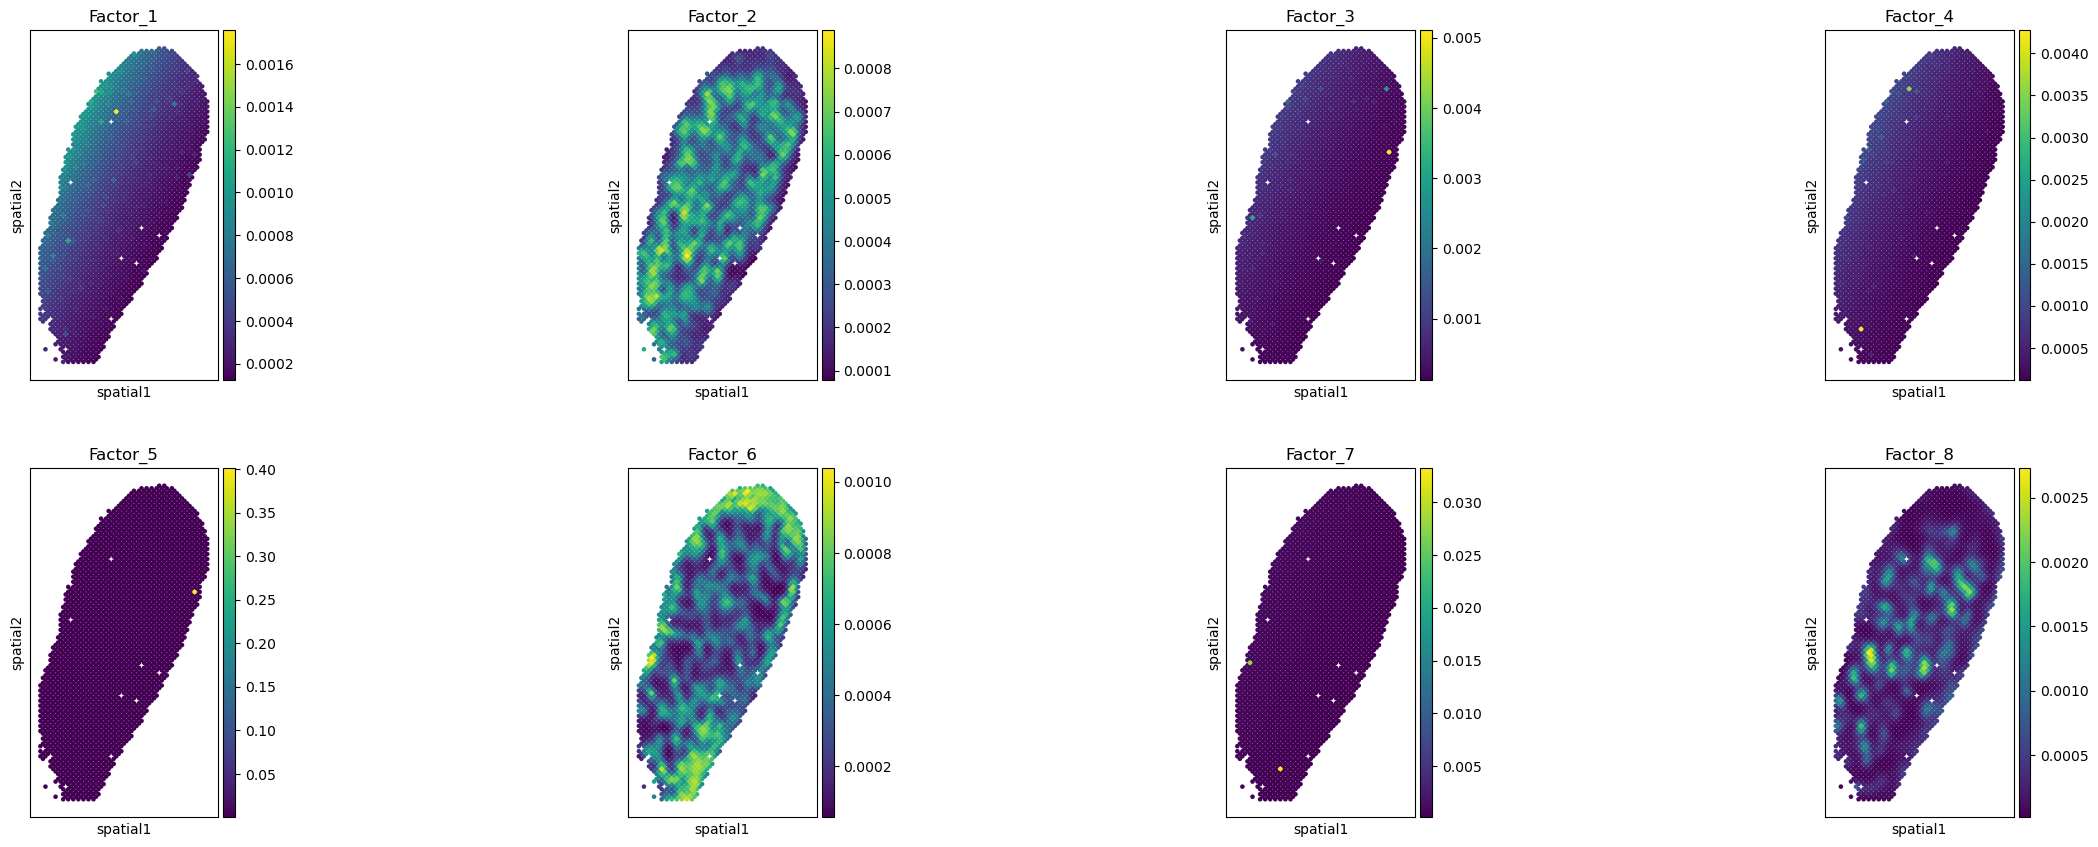

In [47]:
# # 创建图形并保存
# fig = sc.pl.spatial(
#     adata=adata1,
#     color=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])],
#     spot_size=0.1,
#     show=False  # 关键：不显示，只返回图形对象
# )

# # 保存图片
# plt.savefig('spatial_factors.png', 
#             dpi=300, 
#             bbox_inches='tight',  # 紧凑布局
#             facecolor='white')    # 背景色
# plt.close()  # 关闭图形，释放内存

sc.pl.spatial(
    adata=adata1,
    color=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])],
    spot_size=1.8)

阈值分析统计结果
总点位数量: 2568
阈值: [0.6, 0.3, 0.3]
分析的因子: [1, 5, 7]
--------------------------------------------------
各点位因子数量分布:
  有 0 个因子超过阈值: 153 个点位 (5.96%)
  有 1 个因子超过阈值: 2291 个点位 (89.21%)
  有 2 个因子超过阈值: 124 个点位 (4.83%)
  有 3 个因子超过阈值: 0 个点位 (0.00%)
--------------------------------------------------
有 2 个及以上因子超过阈值的点位:
  数量: 124 个
  比例: 4.83%
有 3 个因子超过阈值的点位:
  数量: 0 个
  比例: 0.00%


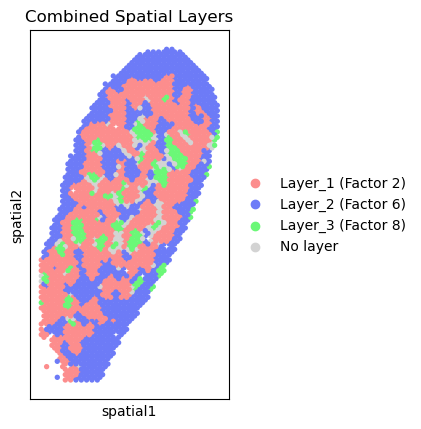


绘制所有图层对比图...


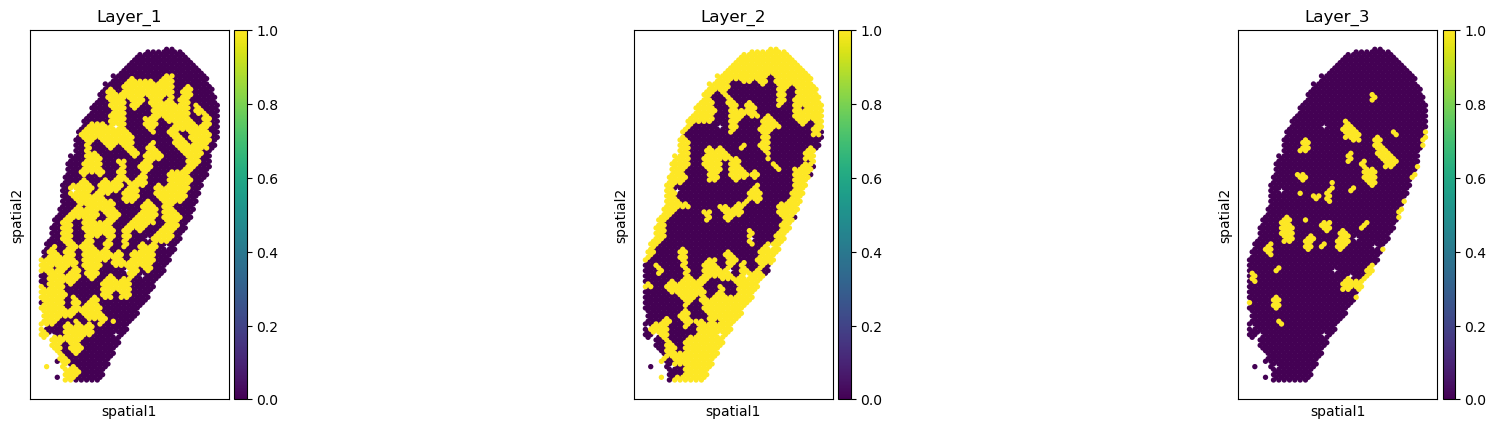

In [20]:
# 1. 首先清除已有的Layer列
layer_cols = [col for col in adata1.obs.columns if col.startswith('Layer_')]
adata1.obs = adata1.obs.drop(columns=layer_cols)
layer_cols = [col for col in adata1.obs.columns if col.startswith('combined_')]
adata1.obs = adata1.obs.drop(columns=layer_cols)
layer_cols = [col for col in adata1.obs.columns if col.startswith('factor_count')]
adata1.obs = adata1.obs.drop(columns=layer_cols)

# 2. 定义要分析的因子
indices = [1, 5, 7]
layer_names = ['Layer_1', 'Layer_2', 'Layer_3']
threshold = [0.6, 0.3, 0.3]

# 3. 为每个图层创建二进制掩码并保存
layer_data = []
layer_masks = []  # 用于统计

for i, name, thres in zip(indices, layer_names, threshold):
    factor_values = H_exp_np_normalized[:, i]
    binary_mask = np.where(factor_values >= thres, 1, 0)
    layer_data.append(binary_mask)
    layer_masks.append(binary_mask)
    
    # 保存到adata1.obs
    tempp = pd.DataFrame(binary_mask, columns=[name])
    tempp.index = adata1.obs.index
    adata1.obs = adata1.obs.join(tempp)

# 4. 创建合并的图层分类
combined_layer = np.zeros(len(H_exp_np_normalized), dtype=int)
max_values = np.zeros(len(H_exp_np_normalized))

# 用于统计每个点位的因子数量
factor_counts = np.zeros(len(H_exp_np_normalized), dtype=int)

for idx in range(len(H_exp_np_normalized)):
    # 收集超过阈值的因子和它们的值
    over_threshold = []
    factor_count = 0
    
    for layer_idx, values in enumerate(layer_data):
        if values[idx] == 1:
            factor_value = H_exp_np_normalized[idx, indices[layer_idx]]
            over_threshold.append((layer_idx + 1, factor_value))  # +1因为从1开始编号
            factor_count += 1
    
    # 记录这个点位的因子数量
    factor_counts[idx] = factor_count
    
    if over_threshold:
        # 找出最大值对应的因子
        max_layer, max_val = max(over_threshold, key=lambda x: x[1])
        combined_layer[idx] = max_layer
        max_values[idx] = max_val
    else:
        combined_layer[idx] = 0
        max_values[idx] = 0

# 5. 将合并的图层信息保存到adata1.obs
adata1.obs['combined_layer'] = combined_layer
adata1.obs['factor_count'] = factor_counts  # 保存因子数量

# 6. 计算统计信息
total_spots = len(H_exp_np_normalized)

# 计算有2个及以上因子超过阈值的点位数量和比例
spots_with_2_or_more = np.sum(factor_counts >= 2)
spots_with_3_or_more = np.sum(factor_counts >= 3)
spots_with_2_only = np.sum(factor_counts == 2)
spots_with_3 = np.sum(factor_counts == 3)

ratio_2_or_more = spots_with_2_or_more / total_spots * 100
ratio_3 = spots_with_3 / total_spots * 100

print("="*50)
print("阈值分析统计结果")
print("="*50)
print(f"总点位数量: {total_spots}")
print(f"阈值: {threshold}")
print(f"分析的因子: {indices}")
print("-"*50)

# 输出详细统计
print("各点位因子数量分布:")
for count in range(4):  # 0, 1, 2, 3个因子
    num_spots = np.sum(factor_counts == count)
    ratio = num_spots / total_spots * 100
    print(f"  有 {count} 个因子超过阈值: {num_spots} 个点位 ({ratio:.2f}%)")

print("-"*50)
print(f"有 2 个及以上因子超过阈值的点位:")
print(f"  数量: {spots_with_2_or_more} 个")
print(f"  比例: {ratio_2_or_more:.2f}%")

print(f"有 3 个因子超过阈值的点位:")
print(f"  数量: {spots_with_3} 个")
print(f"  比例: {ratio_3:.2f}%")

# 7. 创建分类标签
layer_mapping = {
    0: 'No layer',
    1: 'Layer_1 (Factor 2)',
    2: 'Layer_2 (Factor 6)',
    3: 'Layer_3 (Factor 8)'
}
adata1.obs['combined_layer_cat'] = adata1.obs['combined_layer'].map(layer_mapping)

# 创建因子数量分类标签
count_mapping = {
    0: '0 factor',
    1: '1 factor',
    2: '2 factors',
    3: '3 factors'
}
adata1.obs['factor_count_cat'] = adata1.obs['factor_count'].map(count_mapping)

# 8. 使用scanpy绘图
import scanpy as sc

# 8.1 绘制合并图层
sc.pl.spatial(
    adata=adata1,
    color='combined_layer_cat',
    spot_size=2,
    title=f'Combined Spatial Layers',
    palette={
        'No layer': 'lightgray',
        'Layer_1 (Factor 2)': "#FC8D8D",
        'Layer_2 (Factor 6)': "#6D7BF7",  
        'Layer_3 (Factor 8)': "#6BF877"  
    },
    show=True
)

# # 8.2 绘制因子数量分布
# print("\n绘制因子数量分布图...")
# sc.pl.spatial(
#     adata=adata1,
#     color='factor_count_cat',
#     spot_size=1.8,
#     title=f'Factor Count Distribution (Threshold={threshold})',
#     palette={
#         '0 factor': 'lightgray',
#         '1 factor': '#FFB347',  # 橙色
#         '2 factors': '#6D7BF7',  # 蓝色
#         '3 factors': '#FF6B6B'   # 红色
#     },
#     show=True
# )

# 8.3 同时显示所有图
print("\n绘制所有图层对比图...")
sc.pl.spatial(
    adata=adata1,
    color=['Layer_1', 'Layer_2', 'Layer_3'],
    spot_size=2,
    show=True
)

In [41]:
adata1.obsm['latent'] = H_exp_np_normalized
sc.pp.neighbors(adata1, use_rep='latent')
sc.tl.leiden(adata1, resolution=0.03, key_added='leiden')


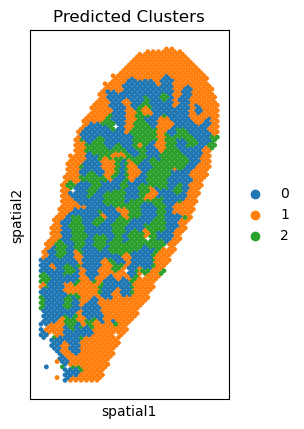

In [43]:
sc.pl.spatial(
    adata1,
    color="leiden",
    spot_size=1.8,
    title='Predicted Clusters'
)

<Axes: title={'center': 'UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

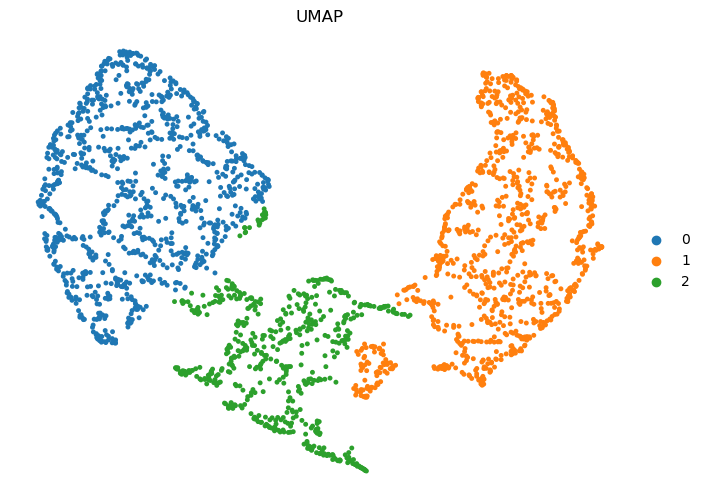

In [44]:
sc.tl.umap(adata1, random_state=42, min_dist=0.3)

# 4. 绘制UMAP图，用聚类结果着色
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sc.pl.umap(
    adata1,
    color='leiden',
    size=50,  # 点的大小
    title='UMAP',
    frameon=False,  # 不显示边框
    ax=ax,
    show=False
)

In [56]:
from matplotlib.patches import Rectangle

W_1 = model.get_W1_W2()[0].detach().cpu().numpy()
W_2 = model.get_W1_W2()[1].detach().cpu().numpy()
gene_names = adata1.var_names.tolist()
ad_names = adata2.var_names.tolist()  # 假设你的第二个模态的变量名

# 选择要可视化的因子
factor_indices = [1, 5, 7]  # Python是0-based索引
factor_names = ['Factor_2', 'Factor_6', 'Factor_8']

W_1_selected = W_1[factor_indices, :]  # 3 × n_genes
W_2_selected = W_2[factor_indices, :]  # 3 × n_peaks or n_ADTs


#normalization

# row_sums_W1 = np.sum(W_1_selected, axis=1, keepdims=True)
# W_1_selected = W_1_selected / row_sums_W1
# row_sums_W2 = np.sum(W_2_selected, axis=1, keepdims=True)
# W_2_selected = W_2_selected / row_sums_W2


row_sums_W1 = np.sum(W_1_selected, axis=1, keepdims=True)
row_means_W1 = row_sums_W1 / W_1_selected.shape[1]
threshold_W1 = 1.0 * row_means_W1
W_1_selected_filtered = np.where(W_1_selected < threshold_W1, 0, W_1_selected)
row_sums_filtered_W1 = W_1_selected.sum(axis=1, keepdims=True)
W_1_selected = W_1_selected_filtered / row_sums_filtered_W1

row_sums_W2 = np.sum(W_2_selected, axis=1, keepdims=True)
row_means_W2 = row_sums_W2 / W_2_selected.shape[1]
threshold_W2 = 1.0 * row_means_W2
W_2_selected_filtered = np.where(W_2_selected < threshold_W2, 0, W_2_selected)
row_sums_filtered_W2 = W_2_selected.sum(axis=1, keepdims=True)
W_2_selected = W_2_selected_filtered / row_sums_filtered_W2



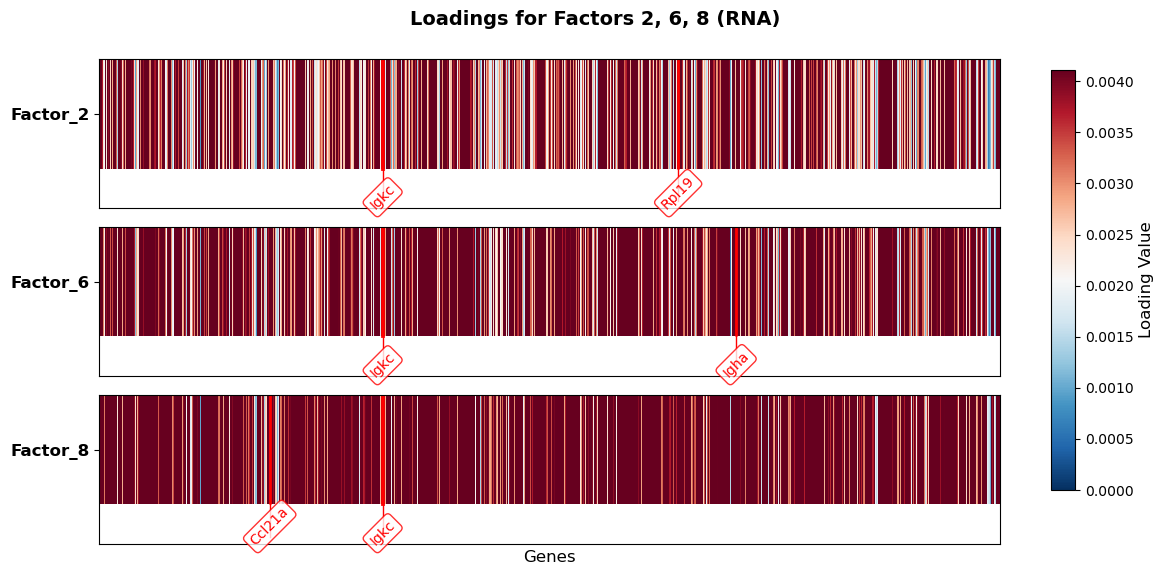

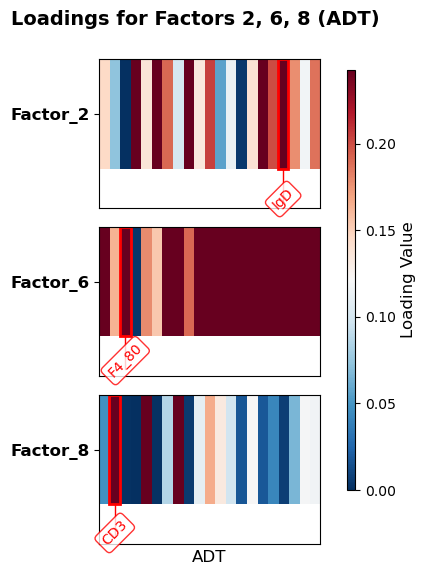

W1 详细信息:

Factor_2:
  正载荷最高: Igkc (0.0400), Rpl19 (0.0337)

Factor_6:
  正载荷最高: Igkc (0.0762), Igha (0.0674)

Factor_8:
  正载荷最高: Igkc (0.0661), Ccl21a (0.0580)

W2 详细信息:

Factor_2:
  正载荷最高: IgD (0.6873), CD169_siglec (0.6698)

Factor_6:
  正载荷最高: F4_80 (0.9746), CD163 (0.8419)

Factor_8:
  正载荷最高: CD3 (0.7287), CD4 (0.6197)


In [66]:

# 图1: W1热力图（三个因子）
fig1, ax1 = plt.subplots(3, 1, figsize=(12, 6))

# 设置全局颜色映射范围
vmin1 = np.min(W_1_selected)
vmax1 = np.max(W_1_selected)

for i, (ax, factor_idx, factor_name) in enumerate(zip(ax1, factor_indices, factor_names)):
    # 获取该因子的载荷
    factor_loadings = W_1[factor_idx, :]
    
    # 创建热图数据
    heatmap_data = factor_loadings.reshape(1, -1)  # 转换为1行
    
    # 绘制热图
    im = ax.imshow(heatmap_data, 
                   cmap='RdBu_r', 
                   aspect='auto',
                   vmin=vmin1,
                   vmax=vmax1)
    
    # 移除y轴
    ax.set_yticks([0])
    ax.set_yticklabels([factor_name], fontsize=12, fontweight='bold')
    
    # 设置x轴（基因）
    ax.set_xticks([])  # 先移除所有x轴刻度
    
    # 找出表达程度最高的前2个基因（正值最大的）
    top_pos_indices = np.argsort(factor_loadings)[-2:][::-1]  # 从大到小排序
    top_pos_genes = [gene_names[idx] for idx in top_pos_indices]
    top_pos_values = factor_loadings[top_pos_indices]
    
    # # 找出表达程度最低的前2个基因（负值最小的，即绝对值最大的负值）
    # top_neg_indices = np.argsort(factor_loadings)[:2]  # 从小到大排序
    # top_neg_genes = [gene_names[idx] for idx in top_neg_indices]
    # top_neg_values = factor_loadings[top_neg_indices]
    
    # 在x轴上标注前2个基因
    # 正值的基因用红色标注在热图上方的位置
    for j, (gene_idx, gene_name, value) in enumerate(zip(top_pos_indices, top_pos_genes, top_pos_values)):
        # 在基因位置上方添加标记
        ax.plot([gene_idx, gene_idx], [0.5, 0.8], 'r-', linewidth=1)
        ax.text(gene_idx, 0.9, gene_name, 
                ha='center', va='bottom', 
                fontsize=10, color='red', rotation=45,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='red'))
        # 在热图上添加小方块标记
        ax.add_patch(Rectangle((gene_idx-0.5, -0.5), 1, 1, 
                              fill=False, edgecolor='red', linewidth=2))
    
    # # 负值的基因用蓝色标注在热图下方的位置
    # for j, (gene_idx, gene_name, value) in enumerate(zip(top_neg_indices, top_neg_genes, top_neg_values)):
    #     # 在基因位置下方添加标记
    #     ax.plot([gene_idx, gene_idx], [-0.2, -0.5], 'b-', linewidth=1)
    #     ax.text(gene_idx, -0.7, gene_name, 
    #             ha='center', va='top', 
    #             fontsize=10, color='blue', rotation=45,
    #             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='blue'))
    #     # 在热图上添加小方块标记
    #     ax.add_patch(Rectangle((gene_idx-0.5, -0.5), 1, 1, 
    #                           fill=False, edgecolor='blue', linewidth=2, linestyle='--'))
    
    # 添加网格线（可选）
    ax.grid(False)
    
    # 只在最后一个子图添加x轴标签
    if i == 2:
        ax.set_xlabel('Genes', fontsize=12)

# 添加颜色条
fig1.subplots_adjust(right=0.85)
cbar_ax = fig1.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig1.colorbar(im, cax=cbar_ax)
cbar.set_label('Loading Value', fontsize=12)

plt.suptitle('Loadings for Factors 2, 6, 8 (RNA)', 
             fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig('W1_factor_loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 图2: W2热力图（三个因子）
fig2, ax2 = plt.subplots(3, 1, figsize=(4, 6))

# 设置全局颜色映射范围
vmin2 = np.min(W_2_selected)
vmax2 = np.max(W_2_selected)

for i, (ax, factor_idx, factor_name) in enumerate(zip(ax2, factor_indices, factor_names)):
    # 获取该因子的载荷
    factor_loadings = W_2[factor_idx, :]
    
    # 创建热图数据
    heatmap_data = factor_loadings.reshape(1, -1)  # 转换为1行
    
    # 绘制热图
    im = ax.imshow(heatmap_data, 
                   cmap='RdBu_r', 
                   aspect='auto',
                   vmin=vmin2,
                   vmax=vmax2)
    
    # 移除y轴
    ax.set_yticks([0])
    ax.set_yticklabels([factor_name], fontsize=12, fontweight='bold')
    
    # 设置x轴
    ax.set_xticks([])  # 先移除所有x轴刻度
    
    # 找出表达程度最高的前2个ADT/peak（正值最大的）
    top_pos_indices = np.argsort(factor_loadings)[-1:][::-1]  # 从大到小排序
    top_pos_names = [ad_names[idx] for idx in top_pos_indices] if 'ad_names' in locals() else [f'Feature_{idx}' for idx in top_pos_indices]
    top_pos_values = factor_loadings[top_pos_indices]
    
    # # 找出表达程度最低的前2个ADT/peak（负值最小的）
    # top_neg_indices = np.argsort(factor_loadings)[:2]  # 从小到大排序
    # top_neg_names = [ad_names[idx] for idx in top_neg_indices] if 'ad_names' in locals() else [f'Feature_{idx}' for idx in top_neg_indices]
    # top_neg_values = factor_loadings[top_neg_indices]
    
    # 在x轴上标注前2个特征
    # 正值的特征用红色标注在热图上方的位置
    for j, (feature_idx, feature_name, value) in enumerate(zip(top_pos_indices, top_pos_names, top_pos_values)):
        # 在特征位置上方添加标记
        ax.plot([feature_idx, feature_idx], [0.5, 0.8], 'r-', linewidth=1)
        ax.text(feature_idx, 0.9, feature_name, 
                ha='center', va='bottom', 
                fontsize=10, color='red', rotation=45,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='red'))
        # 在热图上添加小方块标记
        ax.add_patch(Rectangle((feature_idx-0.5, -0.5), 1, 1, 
                              fill=False, edgecolor='red', linewidth=2))
    
    # # 负值的特征用蓝色标注在热图下方的位置
    # for j, (feature_idx, feature_name, value) in enumerate(zip(top_neg_indices, top_neg_names, top_neg_values)):
    #     # 在特征位置下方添加标记
    #     ax.plot([feature_idx, feature_idx], [-0.2, -0.5], 'b-', linewidth=1)
    #     ax.text(feature_idx, -0.7, feature_name, 
    #             ha='center', va='top', 
    #             fontsize=10, color='blue', rotation=45,
    #             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='blue'))
    #     # 在热图上添加小方块标记
    #     ax.add_patch(Rectangle((feature_idx-0.5, -0.5), 1, 1, 
    #                           fill=False, edgecolor='blue', linewidth=2, linestyle='--'))
    
    # 添加网格线
    ax.grid(False)
    
    # 只在最后一个子图添加x轴标签
    if i == 2:
        ax.set_xlabel('ADT', fontsize=12)

# 添加颜色条
fig2.subplots_adjust(right=0.85)
cbar_ax = fig2.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig2.colorbar(im, cax=cbar_ax)
cbar.set_label('Loading Value', fontsize=12)

plt.suptitle('Loadings for Factors 2, 6, 8 (ADT)', 
             fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig('W2_factor_loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 输出详细信息
print("=" * 80)
print("W1 详细信息:")
print("=" * 80)
for i, (factor_idx, factor_name) in enumerate(zip(factor_indices, factor_names)):
    factor_loadings = W_1[factor_idx, :]
    
    # 正载荷最高的2个基因
    top_pos_indices = np.argsort(factor_loadings)[-4:][::-1]
    top_pos_genes = [gene_names[idx] for idx in top_pos_indices]
    top_pos_values = factor_loadings[top_pos_indices]
    
    # # 负载荷最高的2个基因
    # top_neg_indices = np.argsort(factor_loadings)[:2]
    # top_neg_genes = [gene_names[idx] for idx in top_neg_indices]
    # top_neg_values = factor_loadings[top_neg_indices]
    
    print(f"\n{factor_name}:")
    print(f"  正载荷最高: {top_pos_genes[0]} ({top_pos_values[0]:.4f}), {top_pos_genes[1]} ({top_pos_values[1]:.4f})")
    # print(f"  负载荷最高: {top_neg_genes[0]} ({top_neg_values[0]:.4f}), {top_neg_genes[1]} ({top_neg_values[1]:.4f})")

print("\n" + "=" * 80)
print("W2 详细信息:")
print("=" * 80)
for i, (factor_idx, factor_name) in enumerate(zip(factor_indices, factor_names)):
    factor_loadings = W_2[factor_idx, :]
    
    # 正载荷最高的2个特征
    top_pos_indices = np.argsort(factor_loadings)[-2:][::-1]
    top_pos_names = [ad_names[idx] for idx in top_pos_indices] if 'ad_names' in locals() else [f'Feature_{idx}' for idx in top_pos_indices]
    top_pos_values = factor_loadings[top_pos_indices]
    
    # # 负载荷最高的2个特征
    # top_neg_indices = np.argsort(factor_loadings)[:2]
    # top_neg_names = [ad_names[idx] for idx in top_neg_indices] if 'ad_names' in locals() else [f'Feature_{idx}' for idx in top_neg_indices]
    # top_neg_values = factor_loadings[top_neg_indices]
    
    print(f"\n{factor_name}:")
    print(f"  正载荷最高: {top_pos_names[0]} ({top_pos_values[0]:.4f}), {top_pos_names[1]} ({top_pos_values[1]:.4f})")
    # print(f"  负载荷最高: {top_neg_names[0]} ({top_neg_values[0]:.4f}), {top_neg_names[1]} ({top_neg_values[1]:.4f})")